In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import warnings
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import f1_score, roc_auc_score
import lightgbm as lgb, xgboost as xgb, catboost as cb
from gc import collect
import os
import umap
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.svm import SVC, LinearSVC
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, roc_curve, make_scorer
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, SelectKBest
from sklearn.linear_model import LogisticRegression, RidgeClassifier,RidgeClassifierCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier, StackingClassifier
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE


warnings.filterwarnings("ignore")

# Data Information 

In [3]:
df_dict = pd.read_excel("Dataset/widsdatathon2025/Data Dictionary.xlsx")
df_dict

,DataType,Instrument,Field,Description,Type,Labels
0,QUANTITATIVE METADATA,NaN,NaN,NaN,NaN,NaN
1,NaN,Identifier,participant_id,Participant ID,str,NaN
2,Quantitative,Edinburgh Handedness Questionnaire,EHQ_EHQ_Total,Laterality Index (Score),float,-100 = 10th left\n−28 ≤ LI < 48 = middle\n100 ...
3,Quantitative,Ishihara Color Vision Test,ColorVision_CV_Score,Color vision test score,int,NaN
4,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_CP,Corporal Punishment Score,int,NaN
5,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_ID,Inconsistent Discipline Score,int,NaN
6,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_INV,Involvement Score,int,NaN
7,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_OPD,Other Discipline Practices Score (Not factored...,int,NaN
8,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PM,Poor Monitoring/Supervision Score,int,NaN
9,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PP,Positive Parenting Score,int,NaN


In [4]:
df_submission = pd.read_excel("Dataset/widsdatathon2025/SAMPLE_SUBMISSION.xlsx")
df_submission

,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,0,0
2,ULliyEXjy4OV,0,1
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,1,0
...,...,...,...
299,UadZfjdEg7eG,1,0
300,IUEHiLmQAqCi,1,1
301,cRySmCadYFRO,1,0
302,E3MvDUtJadc5,1,0


# Training Data Information and Types

In [6]:
df_train_cat = pd.read_excel("Dataset/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
df_train_cat

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45
1,CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0
2,Nb4EetVPm3gs,2016,1,1.0,8,1,18,40,0,0
3,p4vPhVu91o4b,2018,3,0.0,8,3,15,30,18,0
4,M09PXs7arQ5E,2019,3,0.0,1,3,15,20,0,0
...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,2019,1,0.0,0,2,21,40,21,40
1209,groSbUfkQngM,2016,1,0.0,0,1,18,35,0,0
1210,zmxGvIrOD0bt,2015,1,1.0,2,1,18,20,0,0
1211,rOmWFuJCud5G,2018,3,0.0,8,3,21,40,18,45


In [7]:
df_train_fmri = pd.read_csv("Dataset/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")
df_train_fmri

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.093473,0.146902,0.067893,0.015141,0.070221,0.063997,0.055382,-0.035335,0.068583,...,0.003404,-0.010359,-0.050968,-0.014365,0.128066,0.112646,-0.058980,0.028228,0.133582,0.143372
1,WHWymJu6zNZi,0.029580,0.179323,0.112933,0.038291,0.104899,0.064250,0.008488,0.077505,-0.004750,...,-0.008409,-0.008479,0.020891,0.017754,0.094040,0.035141,0.032537,0.075007,0.115350,0.138200
2,4PAQp1M6EyAo,-0.051580,0.139734,0.068295,0.046991,0.111085,0.026978,0.151377,0.021198,0.083721,...,0.053245,-0.028003,0.028773,0.024556,0.166343,0.058925,0.035485,0.063661,0.042862,0.162162
3,obEacy4Of68I,0.016273,0.204702,0.115980,0.043103,0.056431,0.057615,0.055773,0.075030,0.001033,...,-0.023918,-0.005356,0.018607,0.016193,0.072955,0.130135,0.056120,0.084784,0.114148,0.190584
4,s7WzzDcmDOhF,0.065771,0.098714,0.097604,0.112988,0.071139,0.085607,0.019392,-0.036403,-0.020375,...,0.066439,-0.076680,-0.047530,-0.031443,0.221213,0.007343,0.005763,0.083820,0.079582,0.067269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,kTurROKp5YHQ,0.022932,0.024830,-0.006514,0.021070,0.093365,0.083369,0.010991,0.035838,0.023909,...,0.060060,-0.003911,-0.016413,0.089110,0.118587,-0.060868,0.124443,0.028510,0.113064,0.103809
1209,FCRyMz9O6yCq,0.047078,0.135955,0.144366,0.054938,0.065760,0.113550,0.032621,0.025349,0.011848,...,0.021318,0.020141,-0.020920,0.030450,0.190241,0.026461,-0.011593,0.139483,-0.064480,0.070354
1210,vm2P1hmAY1hl,0.094541,0.145280,0.061964,0.030562,0.078278,0.105857,0.043984,0.039145,0.032024,...,-0.052990,-0.002118,-0.038452,0.066608,0.143446,0.051221,0.127495,0.106242,-0.036065,0.151341
1211,OFxvN8lnw21w,-0.001533,0.128562,0.045000,-0.008742,0.003673,0.086494,0.090101,-0.037449,-0.026334,...,0.024479,-0.036995,-0.061617,-0.001699,0.106568,0.023427,-0.003520,0.174972,0.041198,0.152029


In [8]:
df_train_fmri[df_train_fmri["participant_id"]=='zmxGvIrOD0bt']

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
969,zmxGvIrOD0bt,0.02471,0.096665,0.053072,0.044169,0.127491,0.023128,0.13307,-0.006838,-0.014219,...,-0.032479,0.079623,-0.058516,-0.030533,0.103685,0.005338,0.051195,0.051761,0.010093,0.117584


In [9]:
df_train_quant = pd.read_excel("Dataset/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
df_train_quant

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,6,1,5,0,5,1,0,10,NaN
1,CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,18,6,8,7,8,10,4,5,NaN
2,Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,14,2,8,5,7,6,4,9,8.239904
3,p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,24,4,16,9,10,8,4,6,NaN
4,M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,18,4,11,4,10,7,3,9,8.940679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,87.80,14,5,14,39,20,15,21,1,9,2,7,3,6,2,0,9,10.697923
1209,groSbUfkQngM,77.80,14,3,10,32,20,11,23,6,18,3,11,9,5,7,4,7,13.964750
1210,zmxGvIrOD0bt,16.68,14,3,16,28,15,19,27,3,4,1,3,0,0,1,0,10,NaN
1211,rOmWFuJCud5G,53.40,14,3,14,34,18,23,23,4,9,0,9,3,5,0,0,9,12.089094


In [10]:
df_train_sol = pd.read_excel("Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx")
df_train_sol

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1
...,...,...,...
1208,Atx7oub96GXS,0,0
1209,groSbUfkQngM,0,1
1210,zmxGvIrOD0bt,0,1
1211,rOmWFuJCud5G,0,0


# Testing Data Information and Types

In [12]:
df_test_cat = pd.read_excel("Dataset/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")
df_test_cat

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0
1,vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0
2,ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0
3,LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0
4,EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0
...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,2023,4,0.0,0.0,4,18.0,0.0,18.0,35.0
300,IUEHiLmQAqCi,2023,4,0.0,1.0,3,18.0,35.0,21.0,40.0
301,cRySmCadYFRO,2023,4,0.0,8.0,4,21.0,25.0,15.0,NaN
302,E3MvDUtJadc5,2022,4,0.0,8.0,4,21.0,0.0,21.0,45.0


In [13]:
df_test_fmri = pd.read_csv("Dataset/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
df_test_fmri

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,0.548480,0.713607,0.557319,0.524369,0.693364,0.770032,0.724406,0.390118,0.547912,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,0.427740,0.363022,0.402862,0.363003,0.534558,0.345347,0.409471,0.303328,0.402515,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,0.139572,0.390106,-0.087041,0.196852,0.088148,0.023843,0.381782,0.068979,0.377488,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,0.133561,0.778326,0.416355,0.471840,0.568460,0.633660,0.501113,0.345461,0.467943,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,0.126699,0.575446,0.509422,0.363193,0.427544,0.449924,0.451796,0.223927,0.298248,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,0.029721,0.596742,0.361898,0.292066,0.553130,0.476284,0.543970,0.372932,0.595183,...,0.021524,-0.162832,0.105546,0.028975,0.576180,0.378365,0.399277,0.556115,0.490833,0.568742
300,IUEHiLmQAqCi,0.025985,0.347840,0.304804,0.463090,0.305321,0.267397,0.468712,0.155677,0.298155,...,0.044974,-0.078047,-0.118271,0.035741,0.640073,0.515096,0.206462,0.536001,0.318518,0.305596
301,cRySmCadYFRO,0.105385,0.443624,-0.019777,0.435582,0.376492,0.619322,0.430177,0.567600,0.399820,...,0.145582,0.004455,0.134574,-0.152951,0.782938,0.737555,0.593972,0.734463,0.680979,0.678973
302,E3MvDUtJadc5,0.345641,0.758986,0.748153,0.442141,0.571924,0.485011,0.530513,0.137672,0.467144,...,0.036169,-0.345563,-0.165280,-0.347035,0.657024,0.590523,0.094565,0.727339,0.429694,0.530238


In [14]:
df_test_quant = pd.read_excel("Dataset/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
df_test_quant

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
1,vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
2,ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
3,LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
4,EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,86.71,14.0,3.0,17.0,41.0,17.0,11.0,25.0,1.0,18.0,7.0,7.0,5.0,6.0,11.0,4.0,7.0,7.546999
300,IUEHiLmQAqCi,73.37,14.0,5.0,12.0,38.0,22.0,9.0,29.0,2.0,16.0,2.0,11.0,5.0,9.0,5.0,3.0,8.0,10.531143
301,cRySmCadYFRO,87.84,13.0,3.0,14.0,42.0,15.0,10.0,28.0,1.0,11.0,4.0,4.0,4.0,3.0,7.0,3.0,10.0,7.210586
302,E3MvDUtJadc5,46.76,14.0,3.0,16.0,43.0,18.0,12.0,22.0,5.0,21.0,2.0,10.0,6.0,5.0,11.0,9.0,0.0,12.212183


# Exploring Features

In [20]:
%%time
def get_feats(mode='train'):
   
    feats=pd.read_excel(f"Dataset/widsdatathon2025/{mode}/{mode}_QUANTITATIVE_METADATA.xlsx")
    
    if mode=='TRAIN':
        cate=pd.read_excel(f"Dataset/widsdatathon2025/{mode}/{mode}_CATEGORICAL_METADATA.xlsx")
    else:
        cate=pd.read_excel(f"Dataset/widsdatathon2025/{mode}/{mode}_CATEGORICAL.xlsx")
    feats=feats.merge(cate,on='participant_id',how='left')
    
    func=pd.read_csv(f"Dataset/widsdatathon2025/{mode}/{mode}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
    feats=feats.merge(func,on='participant_id',how='left')

    if mode=='TRAIN':
        solution=pd.read_excel("Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx")
        feats=feats.merge(solution,on='participant_id',how='left')
        
    return feats
    
train=get_feats(mode='TRAIN')
test=get_feats(mode='TEST')
sub = pd.read_excel('Dataset/widsdatathon2025/SAMPLE_SUBMISSION.xlsx')
y = pd.read_excel(f"Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx")

CPU times: total: 7.36 s
Wall time: 7.36 s


In [21]:
train.set_index('participant_id',inplace=True)
test.set_index('participant_id',inplace=True)
targets = ['ADHD_Outcome','Sex_F']
features = test.columns

In [22]:
def check_for_nulls(df):
  """
  Checks for null values in a pandas DataFrame and prints a message.

  Args:
    df: The pandas DataFrame to check.

  Returns:
    None
  """
  if df.isnull().any().any():
    print("The DataFrame contains null values.")
  else:
    print("The DataFrame does not contain null values.")


check_for_nulls(train)
check_for_nulls(test)
print(f'Train: {train.shape}, Test: {test.shape}')

The DataFrame contains null values.
The DataFrame contains null values.
Train: (1213, 19929), Test: (304, 19927)


In [23]:
train = train.drop(columns=['Basic_Demos_Study_Site', 'Basic_Demos_Study_Site', 'MRI_Track_Scan_Location', 'Basic_Demos_Enroll_Year'])

In [29]:
columns_to_drop = ['Basic_Demos_Study_Site', 'Basic_Demos_Study_Site', 'MRI_Track_Scan_Location', 'Basic_Demos_Enroll_Year']

features = [col for col in features if col not in columns_to_drop]

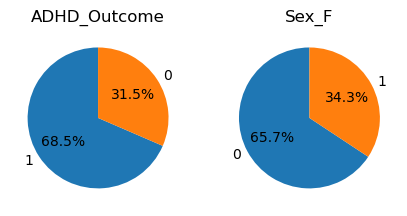

In [30]:
# 1 is ADHD and 1 is Female

fig, axs = plt.subplots(1,2, figsize=(5,3))

for col, ax in zip(y.drop('participant_id',axis=1), axs):    
    counts = y[col].value_counts()
    ax.pie(counts, labels=counts.index, 
           autopct='%1.1f%%', 
           startangle=90)
    ax.set_title(f'{col}')

In [8]:
from scipy.stats import shapiro

shapiro_test_features = {f: shapiro(train[f]).pvalue for f in features if (train[f] >= 0).all()}

shapiro_test_features = dict(sorted(shapiro_test_features.items(), key=lambda item: item[1]))
shapiro_test_features

{'ColorVision_CV_Score': 7.759969677349824e-55,
 'PreInt_Demos_Fam_Child_Race': 9.596149675798612e-44,
 'APQ_P_APQ_P_CP': 7.681005892940669e-41,
 'Basic_Demos_Study_Site': 1.3503507127736513e-40,
 'Barratt_Barratt_P1_Edu': 3.02730326372461e-38,
 'APQ_P_APQ_P_PP': 1.6101990903359345e-36,
 'Barratt_Barratt_P2_Edu': 3.82547615645794e-36,
 'Barratt_Barratt_P1_Occ': 3.256450899569318e-34,
 'APQ_P_APQ_P_INV': 3.5621240937857697e-34,
 'Barratt_Barratt_P2_Occ': 1.0289559975652097e-32,
 'MRI_Track_Scan_Location': 1.0393966298077915e-32,
 'SDQ_SDQ_Conduct_Problems': 4.621192985769595e-30,
 'SDQ_SDQ_Prosocial': 6.531220841529155e-29,
 'SDQ_SDQ_Emotional_Problems': 7.295076364361756e-29,
 'Basic_Demos_Enroll_Year': 1.9395470391901361e-28,
 'SDQ_SDQ_Peer_Problems': 4.3269468507348865e-28,
 'SDQ_SDQ_Internalizing': 3.591882513017715e-22,
 'APQ_P_APQ_P_OPD': 1.963302439304695e-21,
 'SDQ_SDQ_Generating_Impact': 3.9623726597849733e-20,
 'APQ_P_APQ_P_PM': 1.4006611823126052e-19,
 'SDQ_SDQ_Hyperactivity'

In [15]:
import scipy.stats
new_skew = scipy.stats.skew(train["APQ_P_APQ_P_CP"])
print("New skewness after Box-Cox:", new_skew)


New skewness after Box-Cox: 1.569433576495158


In [19]:
from scipy.stats import boxcox

features_to_transform = list(shapiro_test_features.keys())

lambda_values = {}

for f in features_to_transform:
    # Box-Cox requires strictly positive values, so we add a small constant
    train[f], lambda_values[f] = boxcox(train[f] + 1e-6)

print("Optimal lambda values for each feature:")
for f, lmbda in lambda_values.items():
    print(f"{f}: {lmbda}")


Optimal lambda values for each feature:
ColorVision_CV_Score: 1.9005626059855378
PreInt_Demos_Fam_Child_Race: -0.017079976659851854
APQ_P_APQ_P_CP: 0.5960781249737029
Basic_Demos_Study_Site: -0.5050574032775351
Barratt_Barratt_P1_Edu: 1.3616144884626291
APQ_P_APQ_P_PP: 1.5144188455727357
Barratt_Barratt_P2_Edu: 0.34254094751519676
Barratt_Barratt_P1_Occ: 0.18683710224286873
APQ_P_APQ_P_INV: 1.427423333859896
Barratt_Barratt_P2_Occ: 0.20941658609554448
MRI_Track_Scan_Location: 0.9419119295053431
SDQ_SDQ_Conduct_Problems: 0.17459078540965006
SDQ_SDQ_Prosocial: 1.2295357999986032
SDQ_SDQ_Emotional_Problems: 0.21116913717683838
Basic_Demos_Enroll_Year: 92.64416983460093
SDQ_SDQ_Peer_Problems: 0.19640099957188573
SDQ_SDQ_Internalizing: 0.3428135800509715
APQ_P_APQ_P_OPD: 1.0892573099154952
SDQ_SDQ_Generating_Impact: 0.31087823815444465
APQ_P_APQ_P_PM: 0.6912761385628476
SDQ_SDQ_Hyperactivity: 0.5333587951455517
26throw_129thcolumn: 0.8502639023220595
SDQ_SDQ_Externalizing: 0.519512078906991

In [21]:
import scipy.stats
new_skew = scipy.stats.skew(train["APQ_P_APQ_P_CP"])
print("New skewness after Box-Cox:", new_skew)


New skewness after Box-Cox: 0.28302940538545046


In [39]:
log_features = [f for f in features if (train[f] >= 0).all() and scipy.stats.skew(train[f]) > 0] # right tail skew
log_features

['APQ_P_APQ_P_CP',
 'APQ_P_APQ_P_PM',
 'SDQ_SDQ_Conduct_Problems',
 'SDQ_SDQ_Difficulties_Total',
 'SDQ_SDQ_Emotional_Problems',
 'SDQ_SDQ_Externalizing',
 'SDQ_SDQ_Generating_Impact',
 'SDQ_SDQ_Internalizing',
 'SDQ_SDQ_Peer_Problems',
 'PreInt_Demos_Fam_Child_Race',
 '26throw_129thcolumn']

In [9]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(256,128), activation='relu', solver='adam', max_iter=500)



In [21]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, make_scorer
import numpy as np

cv = KFold(n_splits=10, shuffle=True, random_state=42)

model = MultiOutputClassifier(make_pipeline(
    ColumnTransformer([('imputer', SimpleImputer(strategy='median'), features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),
    
    ColumnTransformer([('log', FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),
    
    MinMaxScaler(),
    RidgeClassifier(alpha=100)
))

cv_results = cross_validate(
    model, 
    train.drop(targets, axis=1), 
    y[targets], 
    cv=cv, 
    scoring=make_scorer(f1_score, average='micro'), 
    n_jobs=-1
)

print("Cross-validation F1-micro scores:", cv_results['test_score'])
print("Mean F1-micro score:", np.mean(cv_results['test_score']))


Cross-validation F1-micro scores: [0.74103586 0.7756654  0.68164794 0.70943396 0.76744186 0.71713147
 0.75       0.71428571 0.69958848 0.74590164]
Mean F1-micro score: 0.730213232371724


In [19]:
from sklearn.model_selection import KFold
import numpy as np

# Define 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Get the indices for each fold
folds = list(cv.split(train.drop(targets, axis=1)))

# Select the indices for Fold 2 (index 1 in the list since Python is 0-based)
train_idx, val_idx = folds[1]  # Fold 2

# Extract Fold 2 data
X_fold2_train = train.drop(targets, axis=1).iloc[train_idx]
y_fold2_train = y.drop('participant_id', axis=1).iloc[train_idx]

# Define the model
model = MultiOutputClassifier(make_pipeline(
    ColumnTransformer([('imputer', SimpleImputer(strategy='median'), features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),
    
    ColumnTransformer([('log', FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),
    
    MinMaxScaler(),
    RidgeClassifier(alpha=100)
))

# Train on Fold 2
model.fit(X_fold2_train, y_fold2_train)

# Predict on the test set
y_pred = model.predict(test)

# Save predictions
sub['ADHD_Outcome'] = y_pred[:, 0]
sub['Sex_F'] = y_pred[:, 1]
sub.to_csv('saved_models/submission_v10.csv', index=False)

print("Model trained on Fold 2 and predictions saved!")


✅ Model trained on Fold 2 and predictions saved!


In [13]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(targets,axis=1), 
                                                    y[targets], 
                                                    test_size=0.30, 
                                                    random_state=42)
model = MultiOutputClassifier(make_pipeline(
    ColumnTransformer([('imputer',SimpleImputer(strategy='median'),features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),
    
    ColumnTransformer([('log', 
                        FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),
    
    MinMaxScaler(),
    #mlp
    RidgeClassifier(alpha=100)
))

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print('f1: ', f1_score(y_test,y_pred,average='micro'))

f1:  0.7350199733688415


In [27]:
from sklearn.linear_model import LogisticRegression

# lasso_classifier = LogisticRegression(penalty='l1', solver='liblinear', C=110)  # L1 regularization
lasso_classifier = LogisticRegression(penalty='elasticnet', solver='saga', C=110, l1_ratio=0.6)  # L1 regularization


X_train, X_test, y_train, y_test = train_test_split(train.drop(targets,axis=1), 
                                                    y[targets], 
                                                    test_size=0.30, 
                                                    random_state=42)
model = MultiOutputClassifier(make_pipeline(
    ColumnTransformer([('imputer',SimpleImputer(strategy='median'),features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),
    
    ColumnTransformer([('log', 
                        FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),
    
    MinMaxScaler(),
    #mlp
    lasso_classifier
))

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print('f1: ', f1_score(y_test,y_pred,average='micro'))

f1:  0.7158176943699732


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(train.drop(targets,axis=1), 
                                                    y[targets], 
                                                    test_size=0.30, 
                                                    random_state=42)

# Define hyperparameter grid
param_grid = {
    'estimator__logisticregression__C': np.logspace(-3, 3, 10),  # Regularization strength
    'estimator__logisticregression__l1_ratio': np.linspace(0, 1, 10),  # ElasticNet mixing
}


# Define the base model
lasso_classifier = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=500)

# Create pipeline
model = MultiOutputClassifier(make_pipeline(
    ColumnTransformer([('imputer', SimpleImputer(strategy='median'), features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),

    ColumnTransformer([('log', FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),

    MinMaxScaler(),
    lasso_classifier
))

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=20,
                                   scoring='f1_micro', cv=3, verbose=1, n_jobs=-1, random_state=42)

# Fit the model with hyperparameter tuning
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_
best_score = random_search.best_score_

# Predict with best model
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate final F1-score
final_f1 = f1_score(y_test, y_pred, average='micro')

# Display results
best_params, best_score, final_f1

Fitting 3 folds for each of 20 candidates, totalling 60 fits


({'estimator__logisticregression__l1_ratio': 0.5555555555555556,
  'estimator__logisticregression__C': 0.46415888336127775},
 0.7229224981562963,
 0.7267605633802817)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(train.drop(targets,axis=1), 
                                                    y[targets], 
                                                    test_size=0.30, 
                                                    random_state=42)

# Define the hyperparameter grid with multiple solvers and regularization types
param_grid = {
    'estimator__logisticregression__C': np.logspace(-3, 3, 10),  # Regularization strength
    'estimator__logisticregression__penalty': ['l1', 'l2'],  # Lasso (L1) and Ridge (L2)
    'estimator__logisticregression__solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag'],  # Different solvers
    'estimator__logisticregression__max_iter': [100, 300, 500, 1000],  # Different iteration limits
}

# Define the base logistic regression model
logistic_classifier = LogisticRegression(max_iter=500)

# Create a simple pipeline assuming features and log_features are available
model = MultiOutputClassifier(make_pipeline(
    ColumnTransformer([('imputer', SimpleImputer(strategy='median'), features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),

    ColumnTransformer([('log', FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),

    MinMaxScaler(),
    logistic_classifier
))

# Perform RandomizedSearchCV with L1 and L2 regularization and different solvers
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=30,
                                   scoring='f1_micro', cv=5, verbose=1, n_jobs=-1, random_state=42)

# Fit the model with hyperparameter tuning
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_
best_score = random_search.best_score_

# Predict with best model
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate final F1-score
final_f1 = f1_score(y_test, y_pred, average='micro')

# Display results
best_params, best_score, final_f1


Fitting 5 folds for each of 30 candidates, totalling 150 fits


({'estimator__logisticregression__solver': 'liblinear',
  'estimator__logisticregression__penalty': 'l1',
  'estimator__logisticregression__max_iter': 300,
  'estimator__logisticregression__C': 2.154434690031882},
 0.7449366570178305,
 0.710204081632653)

In [17]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42)))
]

X_train, X_test, y_train, y_test = train_test_split(train.drop(targets,axis=1), 
                                                    y[targets], 
                                                    test_size=0.30, 
                                                    random_state=42)
model = MultiOutputClassifier(make_pipeline(
                        
                              ColumnTransformer([('imputer',SimpleImputer(strategy='median'),features)],
                                               remainder='passthrough',
                                               verbose_feature_names_out=False).set_output(transform='pandas'),
                              ColumnTransformer([('log', 
                                                 FunctionTransformer(np.log1p), log_features)],
                                                 remainder='passthrough'),
                              
                            MinMaxScaler(),    
                              
                            StackingClassifier(estimators=estimators,
                                               final_estimator=RidgeClassifier(alpha=100)
                                               #final_estimator=LogisticRegression()
                                              )))

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print('f1: ', f1_score(y_test,y_pred,average='micro'))

f1:  0.7150259067357513


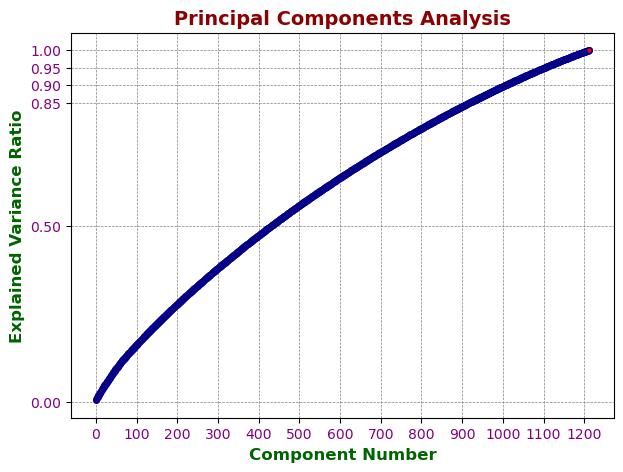

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator

pca = make_pipeline(SimpleImputer(), StandardScaler(), PCA())
pca.fit(train[train.columns])

explained_variance = pca[-1].explained_variance_ratio_.cumsum()

plt.figure(figsize=(7, 5))
plt.plot(explained_variance, color='darkblue', linestyle='-', linewidth=2, marker='o', markerfacecolor='red', markersize=4)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Principal Components Analysis', fontsize=14, fontweight='bold', color='darkred')
plt.xlabel('Component Number', fontsize=12, fontweight='bold', color='darkgreen')
plt.ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold', color='darkgreen')

plt.yticks([0, 0.5, 0.85, 0.90, 0.95, 1], color='purple')
plt.xticks(range(0, 1300, 100), color='purple')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()


In [49]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


X_train, X_test, y_train, y_test = train_test_split(train.drop(targets,axis=1), 
                                                    y[targets], 
                                                    test_size=0.30, 
                                                    random_state=42)
svm_model = MultiOutputClassifier(make_pipeline(
                        
                              ColumnTransformer([('imputer',SimpleImputer(strategy='median'),features)],
                                               remainder='passthrough',
                                               verbose_feature_names_out=False).set_output(transform='pandas'),
                              ColumnTransformer([('log', 
                                                 FunctionTransformer(np.log1p), log_features)],
                                                 remainder='passthrough'),
                              
                            MinMaxScaler(),    
                              
                            SVC(kernel='rbf', C=0.5, probability=True)))

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print('f1: ', f1_score(y_test,y_pred,average='micro'))

f1:  0.687248322147651


In [25]:
from xgboost import XGBClassifier


X_train, X_test, y_train, y_test = train_test_split(train.drop(targets,axis=1), 
                                                    y[targets], 
                                                    test_size=0.30, 
                                                    random_state=42)
xgb_model = MultiOutputClassifier(make_pipeline(
                        
                              ColumnTransformer([('imputer',SimpleImputer(strategy='median'),features)],
                                               remainder='passthrough',
                                               verbose_feature_names_out=False).set_output(transform='pandas'),
                              ColumnTransformer([('log', 
                                                 FunctionTransformer(np.log1p), log_features)],
                                                 remainder='passthrough'),
                              
                            MinMaxScaler(),    
                              
                            XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.8)))

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print('f1: ', f1_score(y_test,y_pred,average='micro'))

f1:  0.687248322147651


In [26]:
train[test.columns]

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
participant_id,,,,,,,,,,,,,,,,,,,,,
UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,6,...,-0.037630,-0.072599,-0.058396,-0.041544,0.142806,-0.006377,0.108005,0.148327,0.093230,-0.004984
CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,18,...,0.014106,-0.001084,-0.025624,-0.031863,0.162011,0.067439,0.017155,0.088893,0.064094,0.194381
Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,14,...,-0.040456,0.018640,0.010771,-0.044341,0.128386,0.047282,0.087678,0.146221,-0.009425,0.035150
p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,24,...,-0.016356,0.025618,-0.007152,0.032584,0.121726,0.045089,0.154464,0.106817,0.065336,0.234708
M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,18,...,-0.056285,-0.031508,-0.010196,0.035638,0.074978,0.030579,0.025640,0.118199,0.112522,0.143666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Atx7oub96GXS,87.80,14,5,14,39,20,15,21,1,9,...,-0.038566,-0.032095,0.030852,-0.009849,0.213448,0.101271,0.054290,0.101367,0.159979,0.149812
groSbUfkQngM,77.80,14,3,10,32,20,11,23,6,18,...,0.015339,-0.028994,-0.096499,0.075038,0.050760,0.103528,0.093136,-0.029158,0.084720,0.135419
zmxGvIrOD0bt,16.68,14,3,16,28,15,19,27,3,4,...,-0.032479,0.079623,-0.058516,-0.030533,0.103685,0.005338,0.051195,0.051761,0.010093,0.117584


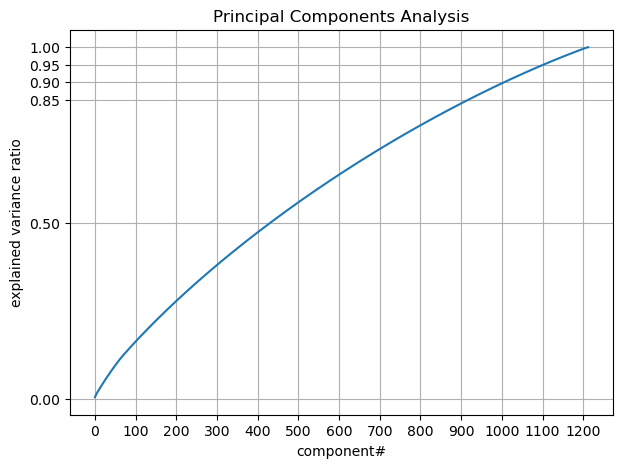

In [24]:
pca = make_pipeline(SimpleImputer(),StandardScaler(),PCA())
pca.fit(train[test.columns])
plt.figure(figsize=(7,5))
plt.plot(pca[-1].explained_variance_ratio_.cumsum())
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Principal Components Analysis')
plt.xlabel('component#')
plt.ylabel('explained variance ratio')
plt.yticks([0,0.5,0.85,0.90,0.95,1])
plt.xticks(range(0,1300,100))
plt.grid()
plt.show()

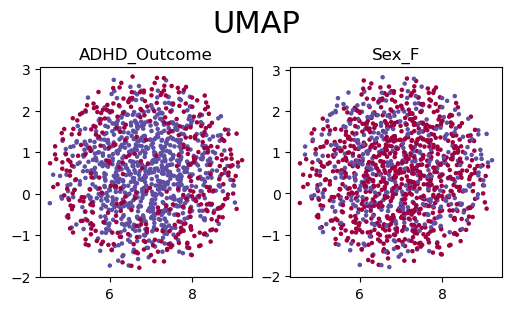

In [10]:
pipe = make_pipeline(SimpleImputer(),MinMaxScaler())
reducer = umap.UMAP()
x_scaler = pipe.fit_transform(train[features])
reducer.fit(x_scaler)
_, axs = plt.subplots(1,2, figsize=(5,3), constrained_layout=True)
embedding = reducer.transform(x_scaler)
for t,ax in zip(targets,axs.ravel()):    
    ax.scatter(embedding[:, 0], embedding[:, 1], c=y[t], cmap='Spectral', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    ax.set_title(f'{t}')
plt.suptitle('UMAP',fontsize=22);

In [23]:
lasso_classifier = LogisticRegression(penalty='l1', solver='liblinear', C=110)  # L1 regularization

model = MultiOutputClassifier(make_pipeline(ColumnTransformer([('imputer',SimpleImputer(strategy='median'),features)],
                                               remainder='passthrough',
                                               verbose_feature_names_out=False).set_output(transform='pandas'),
                                              ColumnTransformer([('log', 
                                                 FunctionTransformer(np.log1p), log_features)],
                                                 remainder='passthrough'),
                                            MinMaxScaler(),  
                                            PCA(1087),
                                            lasso_classifier
                                           ))
model.fit(train.drop(targets,axis=1),
          y.drop('participant_id',axis=1))
y_pred = model.predict(test)
sub['ADHD_Outcome'] = y_pred[:,0]
sub['Sex_F'] = y_pred[:,1]
sub.to_csv('saved_models/submission_v11.csv',index=False)

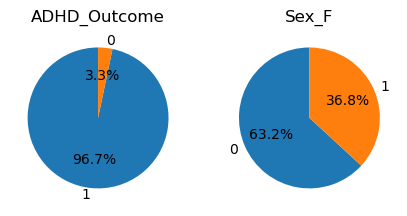

In [23]:
# 1 is ADHD and 1 is Female
df = pd.read_csv("saved_models/submission.csv")

fig, axs = plt.subplots(1,2, figsize=(5,3))

for col, ax in zip(df.drop('participant_id',axis=1), axs):    
    counts = df[col].value_counts()
    ax.pie(counts, labels=counts.index, 
           autopct='%1.1f%%', 
           startangle=90)
    ax.set_title(f'{col}')

In [27]:
df = pd.read_excel(f"Dataset/widsdatathon2025/SAMPLE_SUBMISSION.xlsx")

df.to_csv('saved_models/SAMPLE_SUBMISSION.csv',index=False)

In [23]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42)))
]

model = MultiOutputClassifier(make_pipeline(ColumnTransformer([('imputer',SimpleImputer(strategy='median'),features)],
                                               remainder='passthrough',
                                               verbose_feature_names_out=False).set_output(transform='pandas'),
                                              ColumnTransformer([('log', 
                                                 FunctionTransformer(np.log1p), log_features)],
                                                 remainder='passthrough'),
                                            MinMaxScaler(),  
                                            PCA(1087),
                                            StackingClassifier(estimators=estimators,
                                                               final_estimator=RidgeClassifier(alpha=100)
                                                               #final_estimator=LogisticRegression()
                                                              )))
model.fit(train.drop(targets,axis=1),
          y.drop('participant_id',axis=1))
y_pred = model.predict(test)
sub['ADHD_Outcome'] = y_pred[:,0]
sub['Sex_F'] = y_pred[:,1]
sub.to_csv('saved_models/submission_v5.csv',index=False)

# Same Pipeline but with NN

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Define PyTorch Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.drop3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(128, 2)  # Output layer with 2 neurons (for ADHD_Outcome & Sex_F)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.drop3(x)
        return self.fc4(x)  # No activation here, loss function will handle it


In [11]:
from skorch import NeuralNetClassifier

X_train, X_test, y_train, y_test = train_test_split(train.drop(targets,axis=1), 
                                                    y[targets], 
                                                    test_size=0.30, 
                                                    random_state=42)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train_nn = y_train.to_numpy().astype(np.float32).reshape(-1, 2)
y_test_nn = y_test.to_numpy().astype(np.float32).reshape(-1, 2)

# y_train = torch.tensor(y_train.values, dtype=torch.float32)

# Define Skorch-compatible NeuralNetClassifier
nn_classifier = NeuralNetClassifier(
    module=NeuralNet,
    module__input_size=X_train.shape[1],  # Pass input size dynamically
    max_epochs=50,
    batch_size=64,
    optimizer=optim.AdamW,
    optimizer__lr=0.0001,
    optimizer__weight_decay=0.005,
    criterion=nn.BCEWithLogitsLoss,  # Binary cross-entropy with logits
    iterator_train__shuffle=True,
    device="cuda" if torch.cuda.is_available() else "cpu",  # Use GPU
    train_split=None
)


In [12]:
pipe_nn = make_pipeline(
    ColumnTransformer([('imputer',SimpleImputer(strategy='median'),features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),
    ColumnTransformer([('log', 
                        FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),
    
    MinMaxScaler(),    
    
    nn_classifier)

pipe_nn.fit(X_train,y_train_nn)
y_pred = pipe_nn.predict(X_test)
print('f1: ', f1_score(y_test_nn,y_pred,average='micro'))

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6707  0.2377
      2        0.5433  0.1206
      3        0.4715  0.1336
      4        0.4109  0.1146
      5        0.3594  0.1101
      6        0.3129  0.1105
      7        0.2693  0.1111
      8        0.2364  0.1176
      9        0.2129  0.1161
     10        0.1886  0.1106
     11        0.1701  0.1136
     12        0.1565  0.1101
     13        0.1433  0.1101
     14        0.1355  0.1126
     15        0.1227  0.1136
     16        0.1161  0.1091
     17        0.1085  0.1121
     18        0.1023  0.1126
     19        0.0935  0.1091
     20        0.0909  0.1101
     21        0.0828  0.1106
     22        0.0802  0.1121
     23        0.0756  0.1091
     24        0.0714  0.1101
     25        0.0683  0.1091
     26        0.0653  0.1131
     27        0.0631  0.1106
     28        0.0631  0.1116
     29        0.0555  0.1126
     30        0.0559  0.1146
     31        0.0533  0.1096
     32   

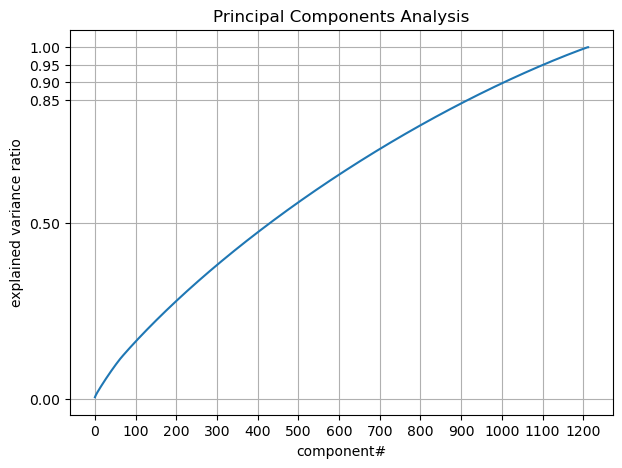

In [23]:
pca = make_pipeline(SimpleImputer(strategy='median'),StandardScaler(),PCA())
pca.fit(train[test.columns])
plt.figure(figsize=(7,5))
plt.plot(pca[-1].explained_variance_ratio_.cumsum())
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Principal Components Analysis')
plt.xlabel('component#')
plt.ylabel('explained variance ratio')
plt.yticks([0,0.5,0.85,0.90,0.95,1])
plt.xticks(range(0,1300,100))
plt.grid()
plt.show()

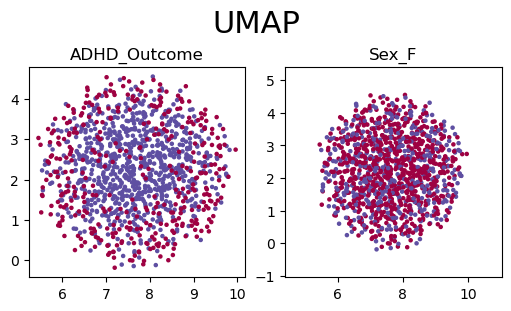

In [27]:
pipe = make_pipeline(SimpleImputer(strategy='median'),MinMaxScaler())
reducer = umap.UMAP()
x_scaler = pipe.fit_transform(train[features])
reducer.fit(x_scaler)
_, axs = plt.subplots(1,2, figsize=(5,3), constrained_layout=True)
embedding = reducer.transform(x_scaler)
for t,ax in zip(targets,axs.ravel()):    
    ax.scatter(embedding[:, 0], embedding[:, 1], c=y[t], cmap='Spectral', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    ax.set_title(f'{t}')
plt.suptitle('UMAP',fontsize=22);

In [30]:
nn_classifier = NeuralNetClassifier(
    module=NeuralNet,
    # module__input_size=1100,  # Must match PCA output size!
    module__input_size=X_train.shape[1],
    max_epochs=50,
    batch_size=64,
    optimizer=optim.AdamW,
    optimizer__lr=0.001,
    optimizer__weight_decay=0.005,
    criterion=nn.BCEWithLogitsLoss,
    iterator_train__shuffle=True,
    device="cuda" if torch.cuda.is_available() else "cpu",
    train_split=None
)


y_train_nn = y.drop('participant_id', axis=1).to_numpy().astype(np.float32)

final_model = make_pipeline(
    ColumnTransformer([('imputer',SimpleImputer(strategy='median'),features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),
    ColumnTransformer([('log',
                        FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),
    MinMaxScaler(),  
    PCA(1087),
    nn_classifier)

final_model.fit(train.drop(targets, axis=1).astype(np.float32), y_train_nn)

y_pred = final_model.predict(test.astype(np.float32))

sub['ADHD_Outcome'] = y_pred[:, 0]
sub['Sex_F'] = y_pred[:, 1]
sub.to_csv('saved_models/submission_v4.csv', index=False)


  epoch    train_loss     dur
-------  ------------  ------
      1        0.6537  0.3672
      2        0.3918  0.1636
      3        0.2031  0.1656
      4        0.1056  0.1706
      5        0.0673  0.1666
      6        0.0431  0.1641
      7        0.0323  0.1751
      8        0.0274  0.1676
      9        0.0205  0.1641
     10        0.0162  0.1736
     11        0.0133  0.1716
     12        0.0115  0.1901
     13        0.0098  0.1946
     14        0.0082  0.1876
     15        0.0075  0.1856
     16        0.0077  0.1851
     17        0.0061  0.1919
     18        0.0050  0.1867
     19        0.0046  0.1857
     20        0.0042  0.1841
     21        0.0037  0.1856
     22        0.0042  0.1826
     23        0.0040  0.1876
     24        0.0031  0.1851
     25        0.0029  0.1846
     26        0.0024  0.1891
     27        0.0023  0.1866
     28        0.0025  0.1841
     29        0.0023  0.1876
     30        0.0022  0.1867
     31        0.0019  0.1892
     32   

# Model Testing

Model Accuracy: 0.6996
ROC-AUC Score: 0.7129

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       160
           1       0.57      0.47      0.52        83

    accuracy                           0.70       243
   macro avg       0.66      0.64      0.65       243
weighted avg       0.69      0.70      0.69       243



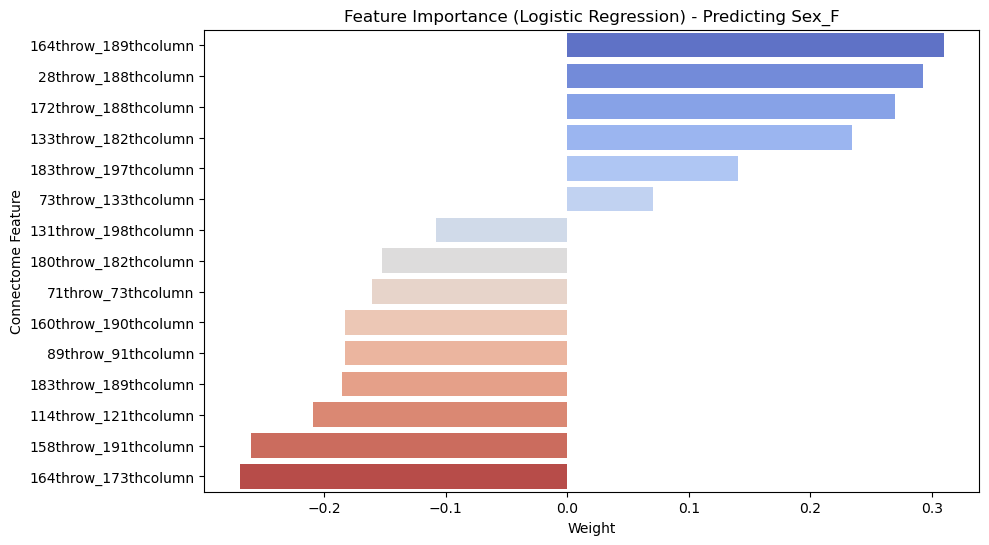

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# File paths for data
train_connectome_path = "Dataset/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_connectome_path = "Dataset/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
training_solution_path = "Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx"

# Load datasets
train_connectome = pd.read_csv(train_connectome_path)
test_connectome = pd.read_csv(test_connectome_path)
train_df = pd.read_excel(training_solution_path)

# Combine Train & Test connectome data
connectome_data = pd.concat([train_connectome, test_connectome], ignore_index=True)

# Clean column names
train_df.columns = train_df.columns.str.strip()
connectome_data.columns = connectome_data.columns.str.strip()

# Define Participant ID (for merging)
participant_id_col = "participant_id"
sex_f_col = "Sex_F"  # Target variable

# Merge Connectome Data with Training Solutions
merged_df = pd.merge(train_df[[participant_id_col, sex_f_col]], connectome_data, on=participant_id_col, how="inner")

# Select the top 50 most correlated features (update based on previous correlation results)
top_features = [
    "164throw_189thcolumn", "164throw_173thcolumn", "158throw_191thcolumn", "28throw_188thcolumn",
    "131throw_198thcolumn", "133throw_182thcolumn", "183throw_189thcolumn", "114throw_121thcolumn",
    "172throw_188thcolumn", "180throw_182thcolumn", "71throw_73thcolumn", "160throw_190thcolumn",
    "183throw_197thcolumn", "73throw_133thcolumn", "89throw_91thcolumn"
]  

# Prepare features (X) - Only using Connectome data, no Sex_F
X = merged_df[top_features]  # Features
y = merged_df[sex_f_col]  # Target (0 = Male, 1 = Female)

# Drop Sex_F from dataset to avoid leakage
X = X.drop(columns=[sex_f_col], errors="ignore")

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

print(f"Model Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance (Weights)
feature_importance = pd.DataFrame({"Feature": top_features, "Weight": model.coef_[0]})
feature_importance = feature_importance.sort_values(by="Weight", ascending=False)

# Visualization: Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance["Weight"], y=feature_importance["Feature"], palette="coolwarm")
plt.title("Feature Importance (Logistic Regression) - Predicting Sex_F")
plt.xlabel("Weight")
plt.ylabel("Connectome Feature")
plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

train_connectome_path = "Dataset/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_connectome_path = "Dataset/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
training_solution_path = "Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx"

train_connectome = pd.read_csv(train_connectome_path)
test_connectome = pd.read_csv(test_connectome_path)
train_df = pd.read_excel(training_solution_path)

train_df.columns = train_df.columns.str.strip()
train_connectome.columns = train_connectome.columns.str.strip()
test_connectome.columns = test_connectome.columns.str.strip()

participant_id_col = "participant_id"
sex_f_col = "Sex_F"

merged_train_df = pd.merge(train_df[[participant_id_col, sex_f_col]], train_connectome, on=participant_id_col, how="inner")

top_features = [
    "164throw_189thcolumn", "164throw_173thcolumn", "158throw_191thcolumn", "28throw_188thcolumn",
    "131throw_198thcolumn", "133throw_182thcolumn", "183throw_189thcolumn", "114throw_121thcolumn",
    "172throw_188thcolumn", "180throw_182thcolumn", "71throw_73thcolumn", "160throw_190thcolumn",
    "183throw_197thcolumn", "73throw_133thcolumn", "89throw_91thcolumn"
]  
top_features = [f for f in top_features if f in train_connectome.columns and f in test_connectome.columns]

X_train = merged_train_df[top_features]
y_train = merged_train_df[sex_f_col]

# (only features, no labels)
X_test = test_connectome[[participant_id_col] + top_features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test[top_features])

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)

sample_submission_path = "Dataset/widsdatathon2025/SAMPLE_SUBMISSION.xlsx"
sample_submission = pd.read_excel(sample_submission_path)

submission = sample_submission.copy()
submission["Sex_F"] = y_test_pred

submission_path = "Dataset/widsdatathon2025/logstic_regression_Submission.csv"
submission.to_csv(submission_path, index=False)

submission_path

'Dataset/widsdatathon2025/logstic_regression_Submission.csv'

In [3]:
sample_submission_path = "Dataset/widsdatathon2025/logstic_regression_Submission.csv"
sample_submission = pd.read_csv(sample_submission_path)
sample_submission.head()

,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,0,0
2,ULliyEXjy4OV,0,0
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,1,0


XGBoost Model Accuracy: 0.6708
XGBoost ROC-AUC Score: 0.6556

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       160
           1       0.52      0.39      0.44        83

    accuracy                           0.67       243
   macro avg       0.62      0.60      0.61       243
weighted avg       0.65      0.67      0.66       243



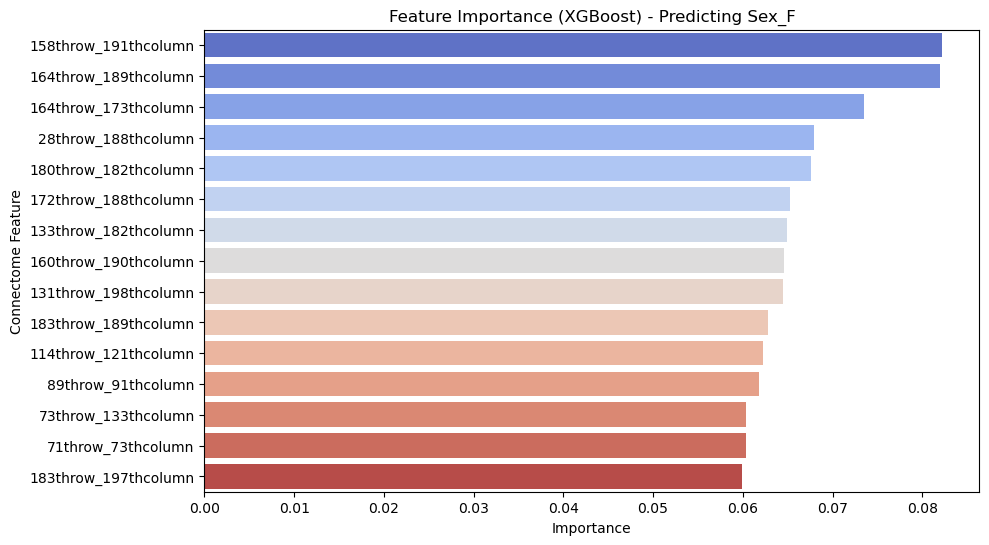

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier

# File paths for data
train_connectome_path = "Dataset/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_connectome_path = "Dataset/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
training_solution_path = "Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx"

# Load datasets
train_connectome = pd.read_csv(train_connectome_path)
test_connectome = pd.read_csv(test_connectome_path)
train_df = pd.read_excel(training_solution_path)

# Combine Train & Test connectome data
connectome_data = pd.concat([train_connectome, test_connectome], ignore_index=True)

# Clean column names
train_df.columns = train_df.columns.str.strip()
connectome_data.columns = connectome_data.columns.str.strip()

# Define Participant ID (for merging)
participant_id_col = "participant_id"
sex_f_col = "Sex_F"  # Target variable

# Merge Connectome Data with Training Solutions
merged_df = pd.merge(train_df[[participant_id_col, sex_f_col]], connectome_data, on=participant_id_col, how="inner")

# Select the top features (update based on correlation results)
top_features = [
    "164throw_189thcolumn", "164throw_173thcolumn", "158throw_191thcolumn", "28throw_188thcolumn",
    "131throw_198thcolumn", "133throw_182thcolumn", "183throw_189thcolumn", "114throw_121thcolumn",
    "172throw_188thcolumn", "180throw_182thcolumn", "71throw_73thcolumn", "160throw_190thcolumn",
    "183throw_197thcolumn", "73throw_133thcolumn", "89throw_91thcolumn"
]  

# Prepare features (X) and target (y)
X = merged_df[top_features]
y = merged_df[sex_f_col]

# Drop Sex_F from dataset to avoid leakage
X = X.drop(columns=[sex_f_col], errors="ignore")

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train XGBoost classifier
xgb_model = XGBClassifier(
        n_estimators=2000, 
        learning_rate=0.03,  
        max_depth=8,
        colsample_bytree=0.8,
        subsample=0.8,
        gamma=1,
        reg_lambda=10,
        reg_alpha=1,
        random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = xgb_model.predict(X_test_scaled)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"XGBoost Model Accuracy: {accuracy:.4f}")
print(f"XGBoost ROC-AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importance = pd.DataFrame({"Feature": top_features, "Importance": xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Visualization: Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="coolwarm")
plt.title("Feature Importance (XGBoost) - Predicting Sex_F")
plt.xlabel("Importance")
plt.ylabel("Connectome Feature")
plt.show()


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Enable CUDA debugging for error tracking
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# File paths
train_connectome_path = "Dataset/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_connectome_path = "Dataset/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_quant_meta_path = "Dataset/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx"
train_cat_meta_path = "Dataset/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx"
test_quant_meta_path = "Dataset/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
test_cat_meta_path = "Dataset/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx"
training_solution_path = "Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx"

# Load datasets
train_connectome = pd.read_csv(train_connectome_path)
test_connectome = pd.read_csv(test_connectome_path)
train_quant_meta = pd.read_excel(train_quant_meta_path)
train_cat_meta = pd.read_excel(train_cat_meta_path)
test_quant_meta = pd.read_excel(test_quant_meta_path)
test_cat_meta = pd.read_excel(test_cat_meta_path)
train_solutions = pd.read_excel(training_solution_path)

# Clean column names
for df in [train_connectome, test_connectome, train_quant_meta, train_cat_meta, test_quant_meta, test_cat_meta, train_solutions]:
    df.columns = df.columns.str.strip()

# Define participant ID and target variables
participant_id_col = "participant_id"
adhd_col = "ADHD_Outcome"
sex_f_col = "Sex_F"

# Merge training datasets
train_df = train_connectome.merge(train_quant_meta, on=participant_id_col).merge(train_cat_meta, on=participant_id_col).merge(train_solutions, on=participant_id_col)

# Merge test datasets
test_df = test_connectome.merge(test_quant_meta, on=participant_id_col).merge(test_cat_meta, on=participant_id_col)

# Ensure target values are strictly 0 or 1
y_train = train_df[[adhd_col, sex_f_col]].astype(float)
if not y_train.isin([0.0, 1.0]).all().all():
    raise ValueError("Target labels contain values other than 0 and 1!")

# Handle missing values and infinities
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
test_df.fillna(0, inplace=True)

# Ensure y_train is updated after dropping NaNs
y_train = y_train.loc[train_df.index]

# Print debug information
print(f"Shapes after cleaning: X_train: {train_df.shape}, y_train: {y_train.shape}")

# Prepare feature and target variables
X_train = train_df.drop(columns=[participant_id_col, adhd_col, sex_f_col])
X_test = test_df.drop(columns=[participant_id_col])
test_participant_ids = test_df[participant_id_col]

# Standardize the data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# Define PyTorch Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.drop3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.drop3(x)
        return self.fc4(x)  # No activation here

# Initialize model
model = NeuralNet(X_train_tensor.shape[1]).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.005)

# Training loop with gradient clipping
epochs = 50
batch_size = 64
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Debugging NaN loss
    if torch.isnan(loss):
        raise ValueError("NaN detected in loss, check inputs and targets.")
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Generate predictions
model.eval()
with torch.no_grad():
    predictions = torch.sigmoid(model(X_test_tensor))
    adhd_pred = (predictions[:, 0] > 0.5).cpu().numpy().astype(int)
    sex_pred = (predictions[:, 1] > 0.5).cpu().numpy().astype(int)

# Create submission file
submission = pd.DataFrame({
    participant_id_col: test_participant_ids,
    adhd_col: adhd_pred,
    sex_f_col: sex_pred
})

# Save submission file
submission_path = "Dataset/widsdatathon2025/Neural_Network_Submission_v3.csv"
submission.to_csv(submission_path, index=False)

# Provide download link
submission_path

Using device: cuda
Shapes after cleaning: X_train: (845, 19930), y_train: (845, 2)
Epoch [10/50], Loss: 0.1805
Epoch [20/50], Loss: 0.0836
Epoch [30/50], Loss: 0.0500
Epoch [40/50], Loss: 0.0320
Epoch [50/50], Loss: 0.0240


'Dataset/widsdatathon2025/Neural_Network_Submission_v3.csv'

In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler

# Enable CUDA debugging for error tracking
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# File paths
train_connectome_path = "Dataset/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_connectome_path = "Dataset/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_quant_meta_path = "Dataset/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx"
train_cat_meta_path = "Dataset/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx"
test_quant_meta_path = "Dataset/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
test_cat_meta_path = "Dataset/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx"
training_solution_path = "Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx"

# Load datasets
train_connectome = pd.read_csv(train_connectome_path)
test_connectome = pd.read_csv(test_connectome_path)
train_quant_meta = pd.read_excel(train_quant_meta_path)
train_cat_meta = pd.read_excel(train_cat_meta_path)
test_quant_meta = pd.read_excel(test_quant_meta_path)
test_cat_meta = pd.read_excel(test_cat_meta_path)
train_solutions = pd.read_excel(training_solution_path)

# Clean column names
for df in [train_connectome, test_connectome, train_quant_meta, train_cat_meta, test_quant_meta, test_cat_meta, train_solutions]:
    df.columns = df.columns.str.strip()

# Define participant ID and target variables
participant_id_col = "participant_id"
adhd_col = "ADHD_Outcome"
sex_f_col = "Sex_F"

# Merge training datasets
train_df = train_connectome.merge(train_quant_meta, on=participant_id_col).merge(train_cat_meta, on=participant_id_col).merge(train_solutions, on=participant_id_col)

# Merge test datasets
test_df = test_connectome.merge(test_quant_meta, on=participant_id_col).merge(test_cat_meta, on=participant_id_col)

# Ensure target values are strictly 0 or 1
y_train = train_df[[adhd_col, sex_f_col]].astype(float)
if not y_train.isin([0.0, 1.0]).all().all():
    raise ValueError("Target labels contain values other than 0 and 1!")

# Handle missing values and infinities
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
test_df.fillna(0, inplace=True)

# Ensure y_train is updated after dropping NaNs
y_train = y_train.loc[train_df.index]

# Print debug information
print(f"Shapes after cleaning: X_train: {train_df.shape}, y_train: {y_train.shape}")

# Prepare feature and target variables
X_train = train_df.drop(columns=[participant_id_col, adhd_col, sex_f_col])
X_test = test_df.drop(columns=[participant_id_col])
test_participant_ids = test_df[participant_id_col]

# Standardize the data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# Define PyTorch Neural Network Model with more complexity
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.drop3 = nn.Dropout(0.4)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.drop4 = nn.Dropout(0.4)
        self.fc5 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.drop3(x)
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.drop4(x)
        return self.fc5(x)  # No activation here

# Implementing Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_predictions = []
for train_idx, val_idx in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.float32).to(device)
    
    # Initialize model
    model = NeuralNet(X_train_tensor.shape[1]).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    
    # Train model
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    # Validate model
    model.eval()
    with torch.no_grad():
        val_predictions = torch.sigmoid(model(X_val_tensor)).cpu().numpy()
    all_predictions.append(val_predictions)

# Final Prediction
model.eval()
with torch.no_grad():
    test_predictions = torch.sigmoid(model(X_test_tensor)).cpu().numpy()

test_submission = pd.DataFrame({
    participant_id_col: test_participant_ids,
    adhd_col: (test_predictions[:, 0] > 0.5).astype(int),
    sex_f_col: (test_predictions[:, 1] > 0.5).astype(int)
})

submission_path = "Dataset/widsdatathon2025/PyTorch_Optimized_Submission.csv"
test_submission.to_csv(submission_path, index=False)
submission_path

Using device: cuda
Shapes after cleaning: X_train: (845, 19930), y_train: (845, 2)


'Dataset/widsdatathon2025/PyTorch_Optimized_Submission.csv'